## 0. 환경설정

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install geopandas
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 시각화 관련
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from PIL import Image
from matplotlib import rc

# 그래프에서 한글 폰트 깨지는 문제에 대한 대처(전역 글꼴 설정)
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore') 

import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

## 1. 전처리
* 구상권코드 + 행정동 + 행정동코드 + 2016,2017

In [26]:
d1 = gpd.read_file('data/서울시_우리마을가게_상권분석서비스(구_상권영역)/TBGIS_TRDAR_RELM.shp',encoding='cp949')
d1 = d1[['TRDAR_CD','ADSTRD_CD']]
d1.columns = ['상권_코드','행정동코드']
d1 = d1.astype('int64')
d1.head(3)
#상권코드 = TRDAR_CD
#ADSTRD_CD

,상권_코드,행정동코드
0,1001453,11620585
1,1001454,11620595
2,1001474,11680650


In [21]:
dfDong = pd.read_excel('data/한국행정구역분류(2022.10.1.기준).xlsx', sheet_name = '행정동 및 법정동코드와의 연계표')
dfDong.rename(columns = dfDong.iloc[0], inplace= True) #첫번째행을 열이름으로
dfDong.drop(dfDong.index[0],inplace=True)#첫번째행삭제
dfDong = dfDong.astype({'행정기관코드':'int64'})
dfDong = dfDong[['행정동\n(행정기관명)','행정기관코드']]
dfDong['행정기관코드'] = dfDong['행정기관코드']/100
dfDong.columns = ['행정동','행정동코드']
dfDong.head(3)
#print(dfDong.info())
#행정기관코드/100

,행정동,행정동코드
1,서울특별시,11000000.0
2,종로구,11110000.0
3,청운효자동,11110515.0


In [28]:
#구상권코드의 행정동코드와 행정동
df = pd.merge(d1,dfDong)
df.head()

,상권_코드,행정동코드,행정동
0,1001453,11620585,낙성대동
1,1000799,11620585,낙성대동
2,1000780,11620585,낙성대동
3,1000781,11620585,낙성대동
4,1001454,11620595,청룡동


In [60]:
df_2015 = pd.read_csv('data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2015년.csv',encoding = 'cp949')
df_2016 = pd.read_csv('data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2016년.csv',encoding = 'cp949')
df_2017 = pd.read_csv('data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2017년.csv',encoding = 'cp949')
#기준_년_코드, 기준_분기_코드,상권_코드,상권_코드_명
#분기당_매출_금액, 분기당_매출_건수,주중_매출_비율,주말_매출_비율 
df_2015 = df_2015[['기준_년_코드','기준_분기_코드','상권_코드','상권_코드_명',
                  '분기당_매출_금액','분기당_매출_건수','주중_매출_비율','주말_매출_비율']]
df_2016 = df_2016[['기준_년_코드','기준_분기_코드','상권_코드','상권_코드_명',
                  '분기당_매출_금액','분기당_매출_건수','주중_매출_비율','주말_매출_비율']]
df_2017 = df_2017[['기준_년_코드','기준_분기_코드','상권_코드','상권_코드_명',
                  '분기당_매출_금액','분기당_매출_건수','주중_매출_비율','주말_매출_비율']]

df_2015 = pd.merge(df,df_2015)
df_2016 = pd.merge(df,df_2016)
df_2017 = pd.merge(df,df_2017)
df_2016.head()
#null값없음 확인

,상권_코드,행정동코드,행정동,기준_년_코드,기준_분기_코드,상권_코드_명,분기당_매출_금액,분기당_매출_건수,주중_매출_비율,주말_매출_비율
0,1001453,11620585,낙성대동,2016,1,낙성대시장,21026126,1378,72,28
1,1001453,11620585,낙성대동,2016,1,낙성대시장,130356503,7795,64,36
2,1001453,11620585,낙성대동,2016,1,낙성대시장,97517609,9090,73,27
3,1001453,11620585,낙성대동,2016,1,낙성대시장,44900446,2604,84,16
4,1001453,11620585,낙성대동,2016,1,낙성대시장,92388940,3108,66,34


## 2. 상업전후 비교
* 행정동단위

### 2-1. 신길로 37길, 가마산로69가길
* 16 & 17 3분기 신길제3동

In [84]:
a = df_2016[(df_2016['행정동']=='신길제3동')& (df_2016['기준_분기_코드']==3)]
b = df_2017[(df_2017['행정동']=='신길제3동')& (df_2017['기준_분기_코드']==3)]
c = pd.concat([a,b])
print(c['기준_년_코드'].unique())
print(c['기준_분기_코드'].unique())
print(c['행정동'].unique())
print(c['상권_코드_명'].unique())
print(c.info())

[2016 2017]
[3]
['신길제3동']
['신길로39길' '가마산로61길' '사러가시장']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 265437 to 264124
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   상권_코드      124 non-null    int64 
 1   행정동코드      124 non-null    int64 
 2   행정동        124 non-null    object
 3   기준_년_코드    124 non-null    int64 
 4   기준_분기_코드   124 non-null    int64 
 5   상권_코드_명    124 non-null    object
 6   분기당_매출_금액  124 non-null    int64 
 7   분기당_매출_건수  124 non-null    int64 
 8   주중_매출_비율   124 non-null    int64 
 9   주말_매출_비율   124 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 10.7+ KB
None


In [88]:
c.groupby('기준_년_코드',as_index=False).mean()
#c = c.astype({'기준_년_코드':'string'})

In [89]:
c.dtypes

상권_코드         int64
행정동코드         int64
행정동          object
기준_년_코드      string
기준_분기_코드      int64
상권_코드_명      object
분기당_매출_금액     int64
분기당_매출_건수     int64
주중_매출_비율      int64
주말_매출_비율      int64
dtype: object

Text(0.5, 1.0, '신길로 37길, 가마산로69가길_행정동단위_분기당_매출_금액')

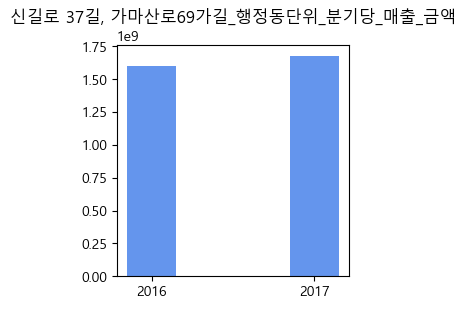

In [96]:
plt.figure(figsize=(3, 3))
plt.bar(c["기준_년_코드"],c["분기당_매출_금액"], color='cornflowerblue',width = 0.3)
#plt.plot(a["항목"],a["관광"], color='mediumpurple')
plt.xticks(rotation=0)
#plt.grid(True)
plt.title("신길로 37길, 가마산로69가길_행정동단위_분기당_매출_금액")

### 2-2. 중앙시장
* 16 & 17 4분기 황학동

In [72]:
a = df_2016[(df_2016['행정동']=='황학동')& (df_2016['기준_분기_코드']==4)]
b = df_2017[(df_2017['행정동']=='황학동')& (df_2017['기준_분기_코드']==4)]
c = pd.concat([a,b])
print(c['기준_년_코드'].unique())
print(c['기준_분기_코드'].unique())
print(c['행정동'].unique())
print(c['상권_코드_명'].unique())
print(c.info())

[2016 2017]
[4]
['황학동']
['난계로11길' '난계로21길' '서울중앙시장']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 285218 to 283974
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   상권_코드      126 non-null    int64 
 1   행정동코드      126 non-null    int64 
 2   행정동        126 non-null    object
 3   기준_년_코드    126 non-null    int64 
 4   기준_분기_코드   126 non-null    int64 
 5   상권_코드_명    126 non-null    object
 6   분기당_매출_금액  126 non-null    int64 
 7   분기당_매출_건수  126 non-null    int64 
 8   주중_매출_비율   126 non-null    int64 
 9   주말_매출_비율   126 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 10.8+ KB
None


In [73]:
c.groupby('기준_년_코드',as_index=False).mean()

,기준_년_코드,상권_코드,행정동코드,기준_분기_코드,분기당_매출_금액,분기당_매출_건수,주중_매출_비율,주말_매출_비율
0,2016,1.000467e+06,11140670.0,4.0,3.328403e+08,10296.444444,75.888889,24.158730
1,2017,1.000467e+06,11140670.0,4.0,3.355472e+08,10522.111111,73.285714,26.825397


## 3. 길단위 -> 전부 실시 이후 증가
* 신길로42가길
* 종로58길 -> 종로58가길
* 새말로18길

### 3-1. **신길로42가길**

In [63]:
a = df_2016[(df_2016['상권_코드_명']=='신길로42가길')& (df_2016['기준_분기_코드']==4)]
b = df_2017[(df_2017['상권_코드_명']=='신길로42가길')& (df_2017['기준_분기_코드']==4)]
c = pd.concat([a,b])
print(c['기준_년_코드'].unique())
print(c['기준_분기_코드'].unique())
print(c['행정동'].unique())
print(c['상권_코드_명'].unique())
print(c.info())

[2016 2017]
[4]
['신길제1동']
['신길로42가길']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 185213 to 184243
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   상권_코드      17 non-null     int64 
 1   행정동코드      17 non-null     int64 
 2   행정동        17 non-null     object
 3   기준_년_코드    17 non-null     int64 
 4   기준_분기_코드   17 non-null     int64 
 5   상권_코드_명    17 non-null     object
 6   분기당_매출_금액  17 non-null     int64 
 7   분기당_매출_건수  17 non-null     int64 
 8   주중_매출_비율   17 non-null     int64 
 9   주말_매출_비율   17 non-null     int64 
dtypes: int64(8), object(2)
memory usage: 1.5+ KB
None


In [64]:
c.groupby('기준_년_코드',as_index=False).mean()

,기준_년_코드,상권_코드,행정동코드,기준_분기_코드,분기당_매출_금액,분기당_매출_건수,주중_매출_비율,주말_매출_비율
0,2016,1000716.0,11560630.0,4.0,8.599459e+07,8456.000,54.555556,45.555556
1,2017,1000716.0,11560630.0,4.0,8.992302e+07,10283.375,55.750000,44.250000


### 3-2. **종로58가길**
* 주말이랑 공휴일만 실시했는데, 주말매출비율 증가!
* 전일제로 실시한 지역과 비교했을 때 주말매출 훨씬증가해서 완전 좋은증거!

In [65]:
a = df_2015[(df_2015['상권_코드_명']=='종로58가길')& (df_2015['기준_분기_코드']==4)]
b = df_2016[(df_2016['상권_코드_명']=='종로58가길')& (df_2016['기준_분기_코드']==4)]
c = pd.concat([a,b])
print(c['기준_년_코드'].unique())
print(c['기준_분기_코드'].unique())
print(c['행정동'].unique())
print(c['상권_코드_명'].unique())
print(c.info())

[2015 2016]
[4]
['숭인제2동']
['종로58가길']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 232964 to 235203
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   상권_코드      49 non-null     int64 
 1   행정동코드      49 non-null     int64 
 2   행정동        49 non-null     object
 3   기준_년_코드    49 non-null     int64 
 4   기준_분기_코드   49 non-null     int64 
 5   상권_코드_명    49 non-null     object
 6   분기당_매출_금액  49 non-null     int64 
 7   분기당_매출_건수  49 non-null     int64 
 8   주중_매출_비율   49 non-null     int64 
 9   주말_매출_비율   49 non-null     int64 
dtypes: int64(8), object(2)
memory usage: 4.2+ KB
None


In [66]:
c.groupby('기준_년_코드',as_index=False).mean()

,기준_년_코드,상권_코드,행정동코드,기준_분기_코드,분기당_매출_금액,분기당_매출_건수,주중_매출_비율,주말_매출_비율
0,2015,1000018.0,11110710.0,4.0,2.278248e+08,14561.800000,77.160000,22.920000
1,2016,1000018.0,11110710.0,4.0,2.332730e+08,16762.458333,72.541667,27.583333


### 3-3. **새말로18길**

In [68]:
a = df_2016[(df_2016['상권_코드_명']=='새말로18길')& (df_2016['기준_분기_코드']==4)]
b = df_2017[(df_2017['상권_코드_명']=='새말로18길')& (df_2017['기준_분기_코드']==4)]
c = pd.concat([a,b])
print(c['기준_년_코드'].unique())
print(c['기준_분기_코드'].unique())
print(c['행정동'].unique())
print(c['상권_코드_명'].unique())
print(c.info())

[2016 2017]
[4]
['구로제5동']
['새말로18길']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 153407 to 152477
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   상권_코드      42 non-null     int64 
 1   행정동코드      42 non-null     int64 
 2   행정동        42 non-null     object
 3   기준_년_코드    42 non-null     int64 
 4   기준_분기_코드   42 non-null     int64 
 5   상권_코드_명    42 non-null     object
 6   분기당_매출_금액  42 non-null     int64 
 7   분기당_매출_건수  42 non-null     int64 
 8   주중_매출_비율   42 non-null     int64 
 9   주말_매출_비율   42 non-null     int64 
dtypes: int64(8), object(2)
memory usage: 3.6+ KB
None


In [69]:
c.groupby('기준_년_코드',as_index=False).mean()

,기준_년_코드,상권_코드,행정동코드,기준_분기_코드,분기당_매출_금액,분기당_매출_건수,주중_매출_비율,주말_매출_비율
0,2016,1000648.0,11530560.0,4.0,3.012239e+08,9801.636364,73.818182,26.272727
1,2017,1000648.0,11530560.0,4.0,3.843541e+08,11396.150000,72.450000,27.700000


## 3. 비고

### 2-3. 신길로 42가길
* 16 & 17 4분기 영등포본동

In [76]:
a = df_2016[(df_2016['행정동']=='영등포본동')& (df_2016['기준_분기_코드']==4)]
b = df_2017[(df_2017['행정동']=='영등포본동')& (df_2017['기준_분기_코드']==4)]
c = pd.concat([a,b])
print(c['기준_년_코드'].unique())
print(c['기준_분기_코드'].unique())
print(c['행정동'].unique())
print(c['상권_코드_명'].unique())
print(c.info())

[2016 2017]
[4]
['영등포본동']
['신길로60길' '영신로9길' '영등포로62길']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 201478 to 200920
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   상권_코드      244 non-null    int64 
 1   행정동코드      244 non-null    int64 
 2   행정동        244 non-null    object
 3   기준_년_코드    244 non-null    int64 
 4   기준_분기_코드   244 non-null    int64 
 5   상권_코드_명    244 non-null    object
 6   분기당_매출_금액  244 non-null    int64 
 7   분기당_매출_건수  244 non-null    int64 
 8   주중_매출_비율   244 non-null    int64 
 9   주말_매출_비율   244 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 21.0+ KB
None


In [77]:
c.groupby('기준_년_코드',as_index=False).mean()

,기준_년_코드,상권_코드,행정동코드,기준_분기_코드,분기당_매출_금액,분기당_매출_건수,주중_매출_비율,주말_매출_비율
0,2016,1.000726e+06,11560515.0,4.0,1.598538e+08,8763.412698,73.269841,26.841270
1,2017,1.000726e+06,11560515.0,4.0,1.732762e+08,10147.881356,70.711864,29.338983
